# **1. Valina GAN (MNIST)**

In [ ]:
import numpy as np
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

First, we download MNIST dataset and examine some sample images.

11493376/11490434 [==============================] - 0s 0us/step


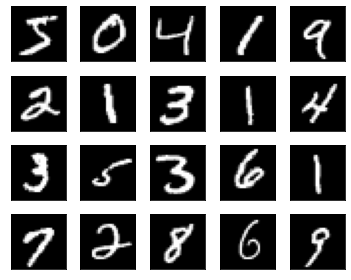

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

plt.figure(figsize=(5, 4))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

## **1.1 Make Valina-GAN**
The input to the generator is called 'latent sample' which is a series of randomly generated numbers. We use the normal distribution here.

Hyperparameters: sample size;

In [ ]:
def make_latent_samples(n_samples, sample_size):
  return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

we use a vector of 100 randomly generated number as a sample

In [ ]:
# generates one sample
make_latent_samples(1, 100) 

array([[-0.73768705,  0.79707071, -0.19723314, -0.54128168, -0.55715322,
         2.26974179, -0.98732237, -1.66048143,  0.47233296,  0.16470538,
        -0.81117349, -0.32982775,  1.2131049 ,  0.66448386,  0.1379414 ,
         0.84696316, -1.53583959, -1.26424969, -0.27715885, -0.0100119 ,
        -0.10306932, -2.07962833,  0.21385855,  0.11793262, -1.97201689,
        -1.71641239,  1.31803346, -0.64117829, -1.14228291,  1.09332922,
        -0.47621838,  0.61610291, -1.732484  ,  0.95488777,  0.7932905 ,
         0.09381961,  0.55643936, -0.89053078, -0.52851243,  0.55665139,
        -0.18676647, -0.02677839, -1.31262348, -0.52402141,  0.13001672,
        -0.85753881, -0.07136637,  1.053895  , -0.0607594 , -3.02710123,
        -1.36985447, -0.90021885, -0.67593736, -0.85416076,  0.46737184,
         0.56263178,  0.31215079, -1.33387012,  0.12306829,  0.41466196,
        -0.47334018, -0.30078187,  0.59733319, -0.04593709, -1.7020249 ,
         0.5670611 , -0.01028516, -0.91380671,  0.3

* The below function combines the generator, discriminator, and GAN models and 
also compile them for training.

* The architecture of **Generator**:


1.   Dense layer: *g_hidden_size* units, take one latent sample (100 values) as input;
2.   LeakyReLU activation;
3.   Dense layer: produces 28*28=784 data points which represent a digit image; we use 'tanh' as activation here since it is one of the best choices according to [1].

* The architecture of **Discriminator**:
1. Dense layer: *d_hidden_size* units, take 784 data points as input;
2. LeakyReLU activation;
3. Dense layer: The last activation is sigmoid to tell us the probability of whether the input image is real or not.

* **GAN**: 

We connect the generator and the discriminator to produce a GAN. It takes the latent sample, and the generator inside GAN produces a digit image which the discriminator inside GAN classifies as real or fake.






[1] ***How to Train a GAN? Tips and tricks to make GANs work.*** Facebook AI Research: Soumith Chintala, Emily Denton, Martin Arjovsky, Michael Mathieu

In [ ]:
def make_valina_GAN(sample_size, g_hidden_size, d_hidden_size, leaky_alpha, g_learning_rate, d_learning_rate):
  keras.backend.clear_session()

  generator = Sequential([
      Dense(g_hidden_size, input_shape=(sample_size,)),
      LeakyReLU(alpha=leaky_alpha),
      Dense(784,activation='tanh')        
  ], name='generator')    

  discriminator = Sequential([
      Dense(d_hidden_size, input_shape=(784,)),
      LeakyReLU(alpha=leaky_alpha),
      Dense(1, activation='sigmoid')
  ], name='discriminator')    

  gan = Sequential([
      generator,
      discriminator
  ])

  discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
  gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')

  return gan, generator, discriminator

## **1.2 Train Valina GAN**

**Preprocess:**

We need to flatten the digit image data as the fully connected input layer expects that. Also, as the generator uses the tanh activation in the output layer, we scale all the MNIST images to have values between -1 and 1.

In [ ]:
def preprocess(x):    
  x = x.reshape(-1, 784) # 784=28*28
  x = np.float64(x)
  x = (x / 255 - 0.5) * 2
  x = np.clip(x, -1, 1)
  return x

In [ ]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

**Deprocessing:**

We also need a function to reverse the preprocessing so that we can display generated images.

In [ ]:
def deprocess(x):
  x = (x / 2 + 1) * 255
  x = np.clip(x, 0, 255)
  x = np.uint8(x)
  x = x.reshape(28, 28)
  return x

Let's examine these two functions on some images: 

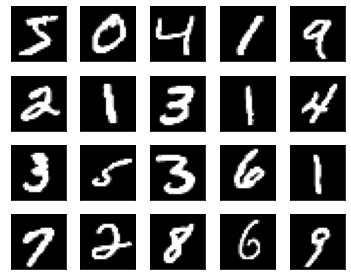

In [ ]:

plt.figure(figsize=(5, 4))
for i in range(20):
  img = deprocess(X_train_real[i])
  plt.subplot(4, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
#The labels are 1 (real) or 0 (fake) in 2D shape.
def make_labels(size):
  return np.ones([size, 1]), np.zeros([size, 1])

While training the GAN, the back-propagation should update the weights of the generator but not the discriminator.

As such, we need a way to make the discriminator trainable and non-trainable.

In [ ]:
# make trainable
def make_trainable(model, trainable):
  for layer in model.layers:
    layer.trainable = trainable

**Training Loop**

We repeat the following to make both the discriminator and the generator better and better:

* Prepare a batch of real images
* Prepare a batch of fake images generated by the generator using latent samples
* Make the discriminator trainable
* Train the discriminator to classify the real and fake images
* Make the discriminator non-trainable
* Train the generator via the GAN

In [ ]:
# hyperparameters
sample_size = 100 # latent sample size (i.e., 100 random numbers)
g_hidden_size = 128
d_hidden_size = 128
leaky_alpha = 0.01
g_learning_rate = 0.0001 # learning rate for the generator
d_learning_rate = 0.001 # learning rate for the discriminator
epochs = 10
batch_size = 64 # train batch size
eval_size = 16 # evaluate size
smooth = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_valina_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
  for i in range(len(X_train_real)//batch_size):
    # real MNIST digit images
    X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
    
    # latent samples and the generated digit images
    latent_samples = make_latent_samples(batch_size, sample_size)
    X_batch_fake = generator.predict_on_batch(latent_samples)
    
    # train the discriminator to detect real and fake images
    make_trainable(discriminator, True)
    discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    discriminator.train_on_batch(X_batch_fake, y_train_fake)

    # train the generator via GAN
    make_trainable(discriminator, False)
    gan.train_on_batch(latent_samples, y_train_real)
  
  # evaluate
  X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
  
  latent_samples = make_latent_samples(eval_size, sample_size)
  X_eval_fake = generator.predict_on_batch(latent_samples)

  d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
  d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
  g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
  
  losses.append((d_loss, g_loss))
  
  print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
      e+1, epochs, d_loss, g_loss))

Epoch:   1/10 Discriminator Loss: 0.2340 Generator Loss: 3.6429
Epoch:   2/10 Discriminator Loss: 0.1434 Generator Loss: 3.7076
Epoch:   3/10 Discriminator Loss: 0.2270 Generator Loss: 2.2539
Epoch:   4/10 Discriminator Loss: 0.3644 Generator Loss: 3.5880
Epoch:   5/10 Discriminator Loss: 0.1601 Generator Loss: 2.6983
Epoch:   6/10 Discriminator Loss: 0.2157 Generator Loss: 2.3662
Epoch:   7/10 Discriminator Loss: 0.2304 Generator Loss: 2.6454
Epoch:   8/10 Discriminator Loss: 0.5456 Generator Loss: 8.0517
Epoch:   9/10 Discriminator Loss: 0.4052 Generator Loss: 3.5438
Epoch:  10/10 Discriminator Loss: 0.3323 Generator Loss: 2.8379


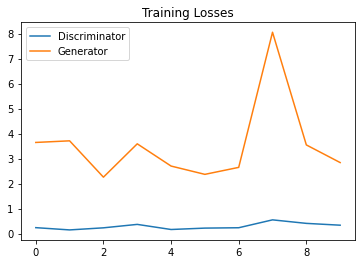

In [ ]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

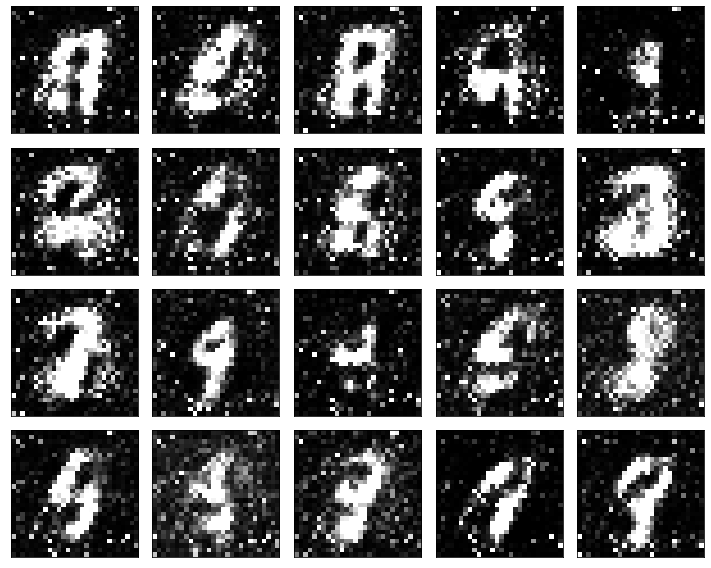

In [ ]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The results are not outstanding as we are using simple networks. Deep Convolutional GAN (aka DCGAN) would produce better results than this. So we then construct a DCGAN.

# **2. Deep Convolutional GAN (DCGAN) (SVHN)**

We need a deeper and more powerful network than the **Valina GAN**. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to Valina GAN are in the generator and discriminator,

In [ ]:
from scipy.io import loadmat
import keras
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## **2.1 Load Data**

In [ ]:
train_data = loadmat('train_32x32.mat')
test_data  = loadmat('test_32x32.mat')
X_train, y_train = train_data['X'], train_data['y']
X_test,  y_test  = test_data['X'],  test_data['y']
# check the shape
X_train.shape

(32, 32, 3, 73257)

We roll the axis backward to make the shape to (records, image_height, image_width, channels).

In [ ]:
# roll axis backward

X_train = np.rollaxis(X_train, 3)
X_test  = np.rollaxis(X_test, 3)
# Check the shape
X_train.shape

(73257, 32, 32, 3)

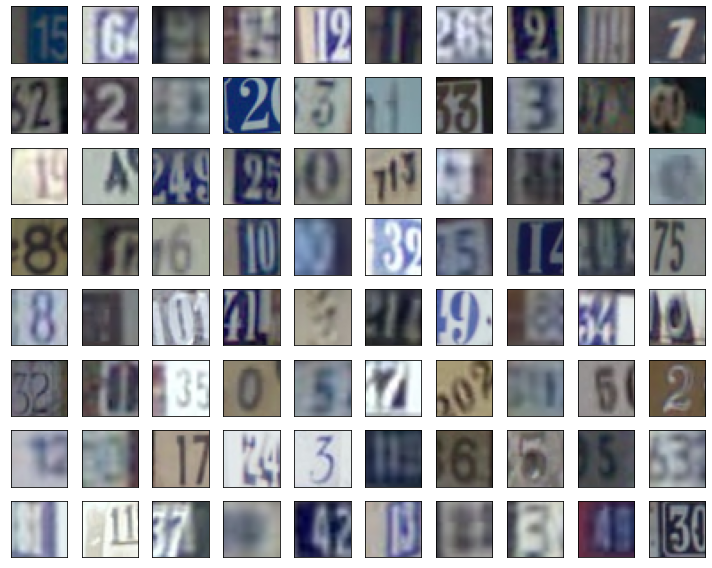

In [ ]:
# Let's examine some sample images.

sample_images = X_train[np.random.choice(len(X_train), size=80, replace=False)]

plt.figure(figsize=(10, 8))
for i in range(80):
  plt.subplot(8, 10, i+1)
  plt.imshow(sample_images[i])
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

## **2.2 Preprocessing and Deprocessing**
As usual, we need preprocessing and later deprocessing of the images.

As we will see later on, the generator is using tanh activation, for which we need to preprocess the image data into the range between -1 and 1.

In [ ]:
def preprocess(x):
  return (x/255)*2-1

def deprocess(x):
  return np.uint8((x+1)/2*255) # make sure to use uint8 type otherwise the image won't display properly

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).


In [ ]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## **2.3 Generator**
The generator takes a latent sample (100 randomly generated numbers) and produces a 32x32 color image that should look like one from the SVHN dataset.

generator network architecture details:

1. Although the size of the images used in the original paper is 64x64, the size of the images in SVHN is 32x32. As such, I used smaller networks.

2. The generator takes a latent sample which has 100 random numbers. It uses the fully connected layer to expand the dimension to  4×4×256  neurons so that it can be reshaped into 4x4 2D shape with 512 filters.

3. After that, each layer's height and width are doubled by the transpose convolution and the filters are halved. The last layer produces a 32x32 2D image with 3 channels.

4. The activation of the output layer is tanh which the discriminator expects;

5. Use Batch Normalization (BN) to stabilize learning by normalizing the input 
to each layer to have zero mean and unit variance;

6. Use Leaky ReLU in all layers of the discriminator. Unlike ReLU, instead 
of zeroing out all outputs when the input is less than zero, Leaky ReLU 
generates a small gradient equal to alpha x input.

In [ ]:
def make_generator(input_size, leaky_alpha):
  # generates images in (32,32,3)
  return Sequential([
    Dense(4*4*512, input_shape=(input_size,)),
    Reshape(target_shape=(4, 4, 512)),                              # 4,4,512
    BatchNormalization(),
    LeakyReLU(alpha=leaky_alpha),
    Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'), # 8,8,256
    BatchNormalization(),
    LeakyReLU(alpha=leaky_alpha),
    Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'), # 16,16,128
    BatchNormalization(),
    LeakyReLU(alpha=leaky_alpha),
    Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')   # 32,32,3
  ])

## **2.4 Discriminator**
The discriminator is a classifier to tell if the input image is real or fake.

It is a convolutional neural network that takes a 32x32 image with 3 channels. The values in the image is expected to be between -1 and 1.

The activation of the output layer is sigmoid and the discriminator outputs a probability of the image being real.

In [ ]:
def make_discriminator(leaky_alpha):
  # classifies images in (32,32,3)
  return Sequential([        
    Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32,32,3)),  # 16,16,64
    LeakyReLU(alpha=leaky_alpha),
    Conv2D(128, kernel_size=5, strides=2, padding='same'),   # 8,8,128
    BatchNormalization(),
    LeakyReLU(alpha=leaky_alpha),
    Conv2D(256, kernel_size=5, strides=2, padding='same'),   # 4,4,256
    BatchNormalization(),
    LeakyReLU(alpha=leaky_alpha),
    Flatten(),
    Dense(1, activation='sigmoid')      
  ])

## **2.5 DCGAN**
We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample. The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN. So, the output of DCGAN is the probability of the generated image being real.

In [ ]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha):
  # clear any session data
  keras.backend.clear_session()
  
  # generator
  generator = make_generator(sample_size, leaky_alpha)

  # discriminator
  discriminator = make_discriminator(leaky_alpha)
  discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
  
  # GAN
  gan = Sequential([generator, discriminator])
  gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
  
  return gan, generator, discriminator

## **2.6 Training DCGAN**
The below is a function to generate latent samples.

In [ ]:
def make_latent_samples(n_samples, sample_size):
  #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
  return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

# The below is a function to set the discriminator to trainable or non-trainable.
def make_trainable(model, trainable):
  for layer in model.layers:
    layer.trainable = trainable

# The below is a function to create a batch of labels.
def make_labels(size):
  return np.ones([size, 1]), np.zeros([size, 1])

# This is to show a epoch - loss chart.
def show_losses(losses):
  losses = np.array(losses)
  
  fig, ax = plt.subplots()
  plt.plot(losses.T[0], label='Discriminator')
  plt.plot(losses.T[1], label='Generator')
  plt.title("Validation Losses")
  plt.legend()
  plt.show()

# This is to show generated images.
def show_images(generated_images):
  n_images = len(generated_images)
  cols = 10
  rows = n_images//cols
  
  plt.figure(figsize=(10, 8))
  for i in range(n_images):
      img = deprocess(generated_images[i])
      ax = plt.subplot(rows, cols, i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
  plt.tight_layout()
  plt.show()

In [ ]:
def train(
    g_learning_rate, # learning rate for the generator
    g_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate, # learning rate for the discriminator
    d_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,
    sample_size=100, # latent sample size (i.e. 100 random numbers)
    epochs=15,
    batch_size= 128, # train batch size
    eval_size=16,    # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
      for i in range(len(X_train_real)//batch_size):
        # real SVHN digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)

        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)

      # evaluate
      X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

      latent_samples = make_latent_samples(eval_size, sample_size)
      X_eval_fake = generator.predict_on_batch(latent_samples)

      d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
      d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
      g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

      losses.append((d_loss, g_loss))

      print("Epoch: {:>3}/{} Discriminator Loss: {:>7.4f}  Generator Loss: {:>7.4f}".format(
          e+1, epochs, d_loss, g_loss))

      # show the generated images
      if (e+1) % 5 == 0:
        show_images(X_eval_fake[:10])
  
    if show_details:
      show_losses(losses)
      show_images(generator.predict(make_latent_samples(80, sample_size)))    
    return generator

### **Traning 1**


Epoch:   1/15 Discriminator Loss:  3.1320  Generator Loss:  1.1729
Epoch:   2/15 Discriminator Loss:  5.3761  Generator Loss:  0.5561
Epoch:   3/15 Discriminator Loss:  4.0039  Generator Loss:  0.2028
Epoch:   4/15 Discriminator Loss:  1.7158  Generator Loss:  1.5672
Epoch:   5/15 Discriminator Loss:  5.2198  Generator Loss:  1.1323


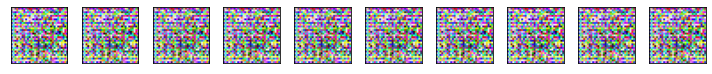

Epoch:   6/15 Discriminator Loss:  3.6292  Generator Loss:  1.6544
Epoch:   7/15 Discriminator Loss:  4.5192  Generator Loss:  2.6973
Epoch:   8/15 Discriminator Loss:  3.4882  Generator Loss:  1.8580
Epoch:   9/15 Discriminator Loss:  4.7503  Generator Loss:  3.0886
Epoch:  10/15 Discriminator Loss:  7.8125  Generator Loss:  3.2107


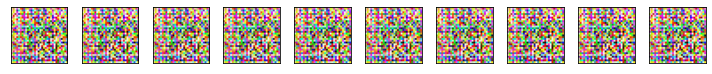

Epoch:  11/15 Discriminator Loss:  2.9559  Generator Loss:  0.1157
Epoch:  12/15 Discriminator Loss:  2.8413  Generator Loss:  0.1202
Epoch:  13/15 Discriminator Loss:  0.7558  Generator Loss:  1.0543
Epoch:  14/15 Discriminator Loss:  2.7915  Generator Loss:  0.3881
Epoch:  15/15 Discriminator Loss:  0.0051  Generator Loss:  5.2959


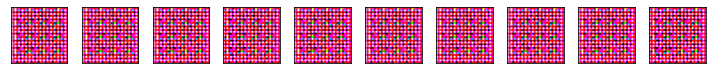

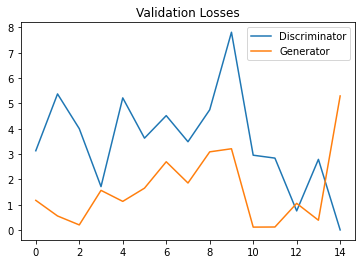

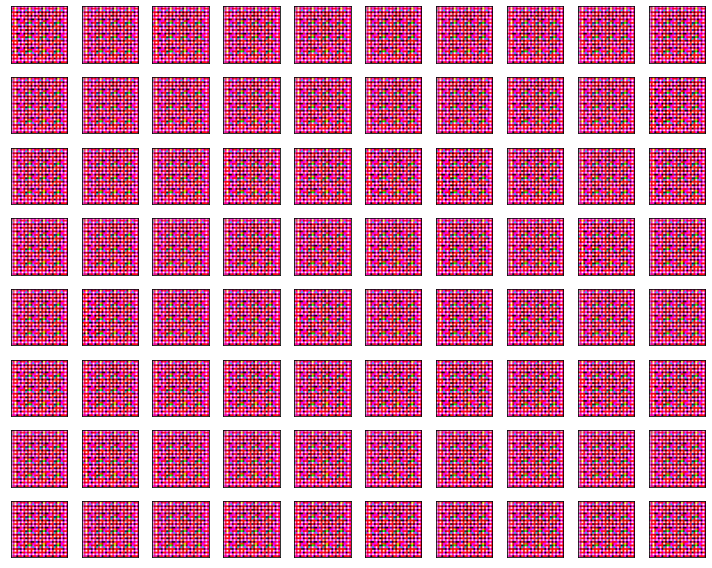

In [ ]:
train(g_learning_rate=0.0002, g_beta_1=0.5, d_learning_rate=0.0002, d_beta_1=0.5, leaky_alpha=0.2)

As we can see:
1. The generated images are garbages;
2. The Discriminator Loss and Generator Loss are flactuating.

So we need to change some hyperparameters. In the **Training 2**, I reduce the generator learning rate and increase the discriminator learning rate.


### **Training 2**

Epoch:   1/30 Discriminator Loss:  1.2328  Generator Loss:  3.3487
Epoch:   2/30 Discriminator Loss:  0.5246  Generator Loss:  1.7293
Epoch:   3/30 Discriminator Loss:  1.0402  Generator Loss:  1.6299
Epoch:   4/30 Discriminator Loss:  1.5336  Generator Loss:  1.0431
Epoch:   5/30 Discriminator Loss:  1.1046  Generator Loss:  1.1122


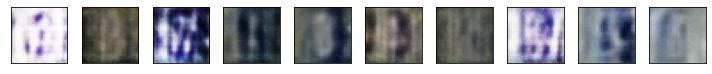

Epoch:   6/30 Discriminator Loss:  1.3320  Generator Loss:  0.7896
Epoch:   7/30 Discriminator Loss:  1.0783  Generator Loss:  1.0096
Epoch:   8/30 Discriminator Loss:  1.4289  Generator Loss:  1.9215
Epoch:   9/30 Discriminator Loss:  1.0953  Generator Loss:  1.5011
Epoch:  10/30 Discriminator Loss:  0.9044  Generator Loss:  1.4669


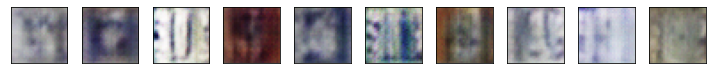

Epoch:  11/30 Discriminator Loss:  1.2514  Generator Loss:  1.2388
Epoch:  12/30 Discriminator Loss:  1.1537  Generator Loss:  1.2787
Epoch:  13/30 Discriminator Loss:  1.2757  Generator Loss:  2.8621
Epoch:  14/30 Discriminator Loss:  1.1984  Generator Loss:  2.5152
Epoch:  15/30 Discriminator Loss:  1.0648  Generator Loss:  1.8739


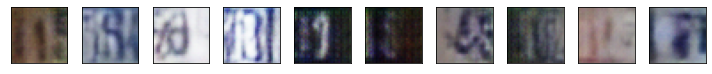

Epoch:  16/30 Discriminator Loss:  1.8536  Generator Loss:  3.2525
Epoch:  17/30 Discriminator Loss:  1.6353  Generator Loss:  1.9819
Epoch:  18/30 Discriminator Loss:  1.5115  Generator Loss:  2.2249
Epoch:  19/30 Discriminator Loss:  1.7402  Generator Loss:  2.9766
Epoch:  20/30 Discriminator Loss:  1.4333  Generator Loss:  2.7174


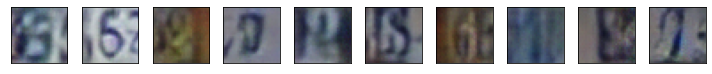

Epoch:  21/30 Discriminator Loss:  1.4849  Generator Loss:  3.6122
Epoch:  22/30 Discriminator Loss:  1.6092  Generator Loss:  1.9829
Epoch:  23/30 Discriminator Loss:  1.8758  Generator Loss:  3.2621
Epoch:  24/30 Discriminator Loss:  2.2722  Generator Loss:  3.7564
Epoch:  25/30 Discriminator Loss:  1.6618  Generator Loss:  2.6658


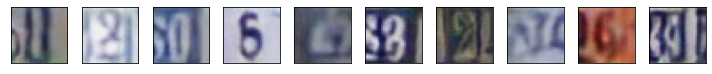

Epoch:  26/30 Discriminator Loss:  1.9160  Generator Loss:  2.6513
Epoch:  27/30 Discriminator Loss:  1.6966  Generator Loss:  2.8653
Epoch:  28/30 Discriminator Loss:  2.3255  Generator Loss:  3.3123
Epoch:  29/30 Discriminator Loss:  1.3739  Generator Loss:  3.9202
Epoch:  30/30 Discriminator Loss:  1.8384  Generator Loss:  3.1068


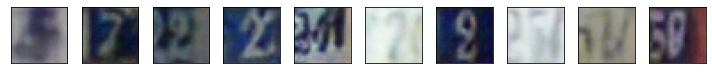

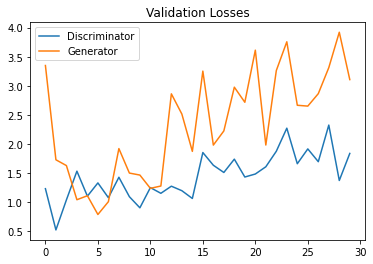

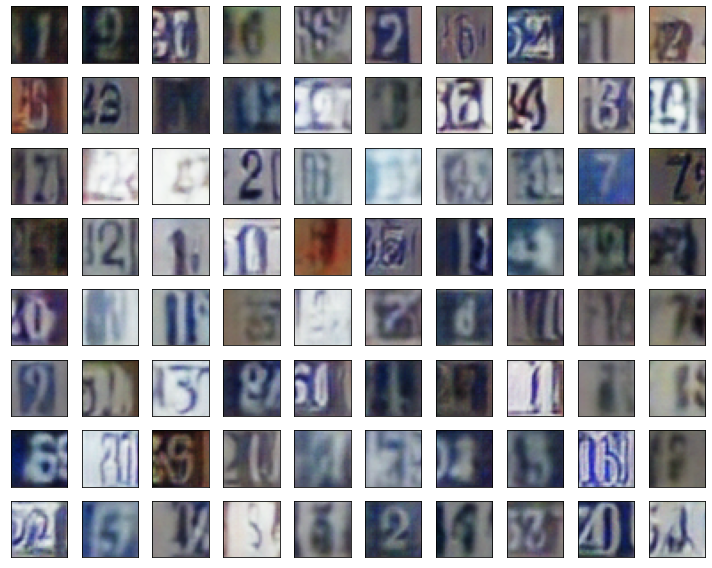

In [ ]:
train(g_learning_rate=0.0001, g_beta_1=0.5, d_learning_rate=0.01,d_beta_1=0.5,leaky_alpha=0.2,epochs=30)

* The generated images are much better than those generated in **Training 1**;
* Both Discriminator Loss and Generator Loss are more stable;
* More hyperparameters should be tuned if we need 

Then I tried some more sets of parameters, the results are not improved muc. Therefore, I choose the set of parameters in **Training 2** as my best and final choice.

Epoch:   1/30 Discriminator Loss:  1.2770  Generator Loss:  1.2363
Epoch:   2/30 Discriminator Loss:  1.1612  Generator Loss:  0.6235
Epoch:   3/30 Discriminator Loss:  1.1418  Generator Loss:  2.7275
Epoch:   4/30 Discriminator Loss:  1.6934  Generator Loss:  2.7327
Epoch:   5/30 Discriminator Loss:  1.0131  Generator Loss:  1.1130


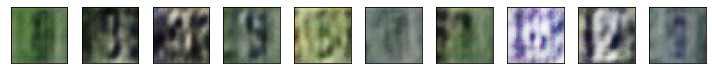

Epoch:   6/30 Discriminator Loss:  0.9883  Generator Loss:  0.9592
Epoch:   7/30 Discriminator Loss:  1.4496  Generator Loss:  5.7391
Epoch:   8/30 Discriminator Loss:  0.7999  Generator Loss:  1.4972
Epoch:   9/30 Discriminator Loss:  0.9019  Generator Loss:  1.2910
Epoch:  10/30 Discriminator Loss:  0.9362  Generator Loss:  1.1241


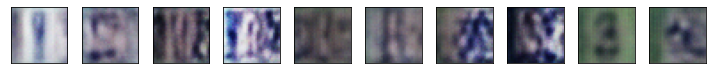

Epoch:  11/30 Discriminator Loss:  1.2916  Generator Loss:  1.8772
Epoch:  12/30 Discriminator Loss:  1.1768  Generator Loss:  2.8164
Epoch:  13/30 Discriminator Loss:  1.2232  Generator Loss:  1.5949
Epoch:  14/30 Discriminator Loss:  1.3712  Generator Loss:  2.1175
Epoch:  15/30 Discriminator Loss:  0.8710  Generator Loss:  2.7578


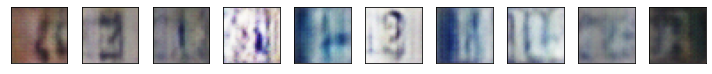

Epoch:  16/30 Discriminator Loss:  1.0078  Generator Loss:  2.7250
Epoch:  17/30 Discriminator Loss:  1.0945  Generator Loss:  1.5822
Epoch:  18/30 Discriminator Loss:  1.8182  Generator Loss:  1.4925
Epoch:  19/30 Discriminator Loss:  2.7788  Generator Loss:  4.6726
Epoch:  20/30 Discriminator Loss:  1.0106  Generator Loss:  2.6580


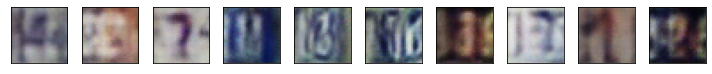

Epoch:  21/30 Discriminator Loss:  1.4743  Generator Loss:  2.4036
Epoch:  22/30 Discriminator Loss:  1.3832  Generator Loss:  3.7150
Epoch:  23/30 Discriminator Loss:  1.4561  Generator Loss:  2.4335
Epoch:  24/30 Discriminator Loss:  1.3333  Generator Loss:  2.5840
Epoch:  25/30 Discriminator Loss:  1.5454  Generator Loss:  2.7812


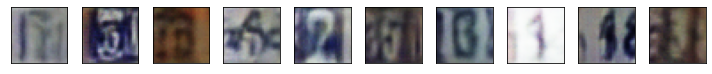

Epoch:  26/30 Discriminator Loss:  1.9799  Generator Loss:  3.0500
Epoch:  27/30 Discriminator Loss:  1.0310  Generator Loss:  2.1579
Epoch:  28/30 Discriminator Loss:  1.6047  Generator Loss:  2.6711
Epoch:  29/30 Discriminator Loss:  1.1138  Generator Loss:  2.5873
Epoch:  30/30 Discriminator Loss:  2.2034  Generator Loss:  2.4170


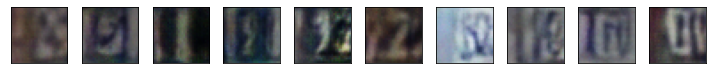

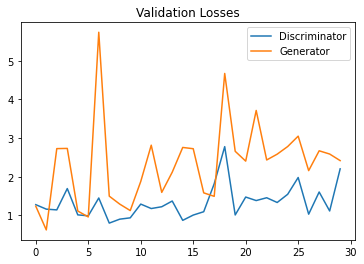

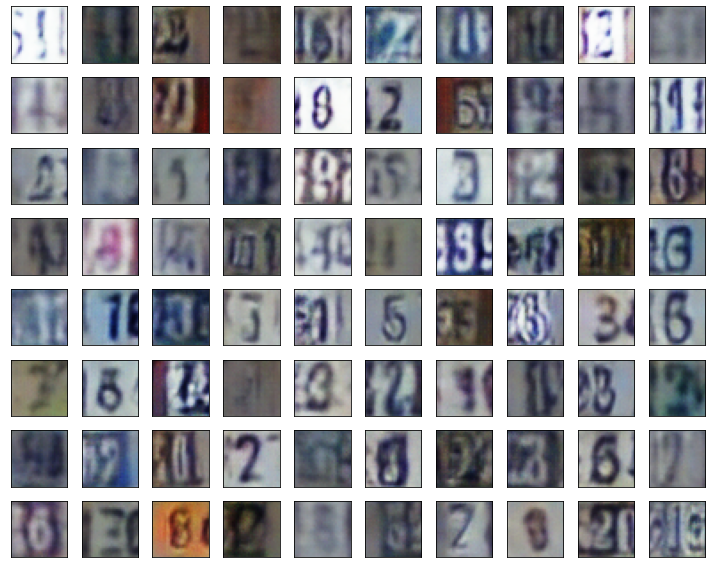

In [ ]:
train(g_learning_rate=0.00005, g_beta_1=0.5, d_learning_rate=0.02,d_beta_1=0.5,leaky_alpha=0.2,epochs=30)

Epoch:   1/30 Discriminator Loss:  0.3767  Generator Loss:  2.5520
Epoch:   2/30 Discriminator Loss:  2.6239  Generator Loss:  1.6784
Epoch:   3/30 Discriminator Loss:  2.7168  Generator Loss:  0.5637
Epoch:   4/30 Discriminator Loss:  2.4379  Generator Loss:  3.6998
Epoch:   5/30 Discriminator Loss:  0.8477  Generator Loss:  1.5089


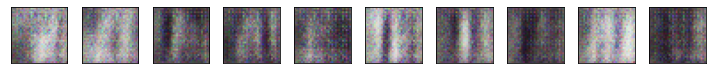

Epoch:   6/30 Discriminator Loss:  0.6542  Generator Loss:  2.2797
Epoch:   7/30 Discriminator Loss:  0.6824  Generator Loss:  2.8205
Epoch:   8/30 Discriminator Loss:  2.0235  Generator Loss:  2.1989
Epoch:   9/30 Discriminator Loss:  2.5013  Generator Loss:  4.2709
Epoch:  10/30 Discriminator Loss:  2.8175  Generator Loss:  6.1106


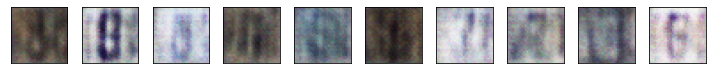

Epoch:  11/30 Discriminator Loss:  1.7955  Generator Loss:  6.0395
Epoch:  12/30 Discriminator Loss:  7.9617  Generator Loss: 33.5875
Epoch:  13/30 Discriminator Loss:  0.8088  Generator Loss:  3.6637
Epoch:  14/30 Discriminator Loss:  6.6866  Generator Loss: 19.4845
Epoch:  15/30 Discriminator Loss:  0.6776  Generator Loss:  2.9917


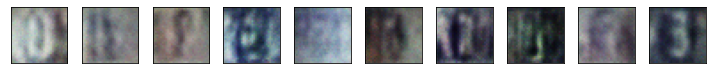

Epoch:  16/30 Discriminator Loss:  0.5247  Generator Loss:  2.2894
Epoch:  17/30 Discriminator Loss:  0.9597  Generator Loss:  2.0207
Epoch:  18/30 Discriminator Loss:  0.9406  Generator Loss:  2.4064
Epoch:  19/30 Discriminator Loss:  1.4748  Generator Loss:  2.4886
Epoch:  20/30 Discriminator Loss:  0.8626  Generator Loss:  1.0927


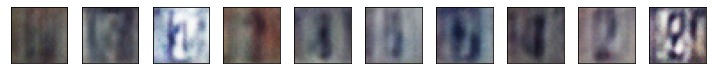

Epoch:  21/30 Discriminator Loss:  1.5593  Generator Loss:  2.1576
Epoch:  22/30 Discriminator Loss:  1.5161  Generator Loss:  2.1021
Epoch:  23/30 Discriminator Loss:  1.7569  Generator Loss:  3.4592
Epoch:  24/30 Discriminator Loss:  0.7784  Generator Loss:  3.1416
Epoch:  25/30 Discriminator Loss:  2.1753  Generator Loss:  4.0277


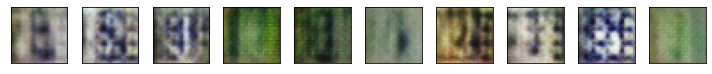

Epoch:  26/30 Discriminator Loss:  1.6717  Generator Loss:  2.8912
Epoch:  27/30 Discriminator Loss: 24.0483  Generator Loss: 73.3400
Epoch:  28/30 Discriminator Loss:  1.1593  Generator Loss:  2.2006
Epoch:  29/30 Discriminator Loss:  0.5993  Generator Loss:  2.8796
Epoch:  30/30 Discriminator Loss:  0.8830  Generator Loss:  2.9070


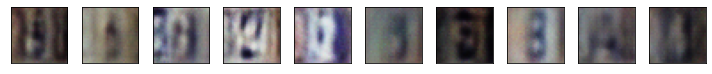

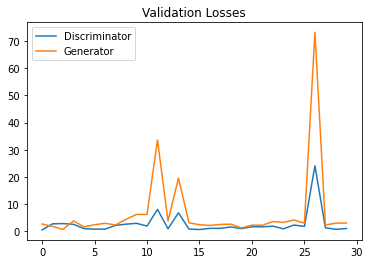

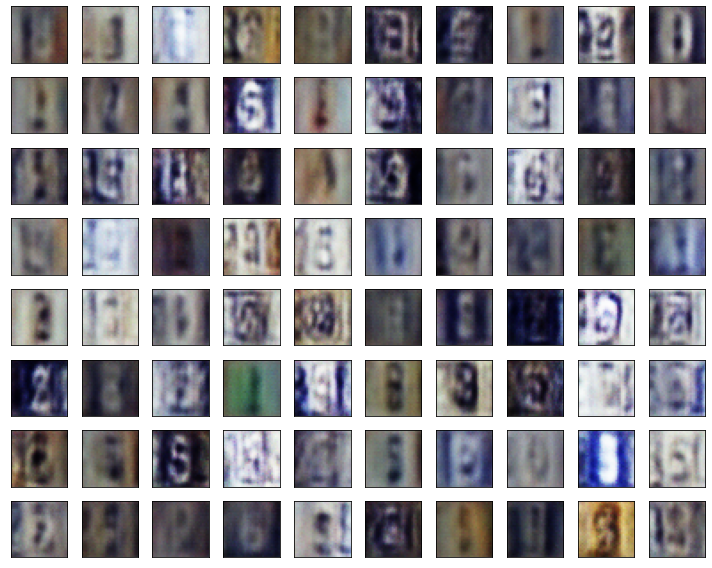

In [ ]:
train(g_learning_rate=0.00001, g_beta_1=0.5, d_learning_rate=0.05,d_beta_1=0.5,leaky_alpha=0.2,epochs=30)

Epoch:   1/30 Discriminator Loss:  0.6745  Generator Loss:  2.3839
Epoch:   2/30 Discriminator Loss:  1.1585  Generator Loss:  1.7885
Epoch:   3/30 Discriminator Loss:  0.4340  Generator Loss:  3.1496
Epoch:   4/30 Discriminator Loss:  0.8113  Generator Loss:  3.2219
Epoch:   5/30 Discriminator Loss:  1.8869  Generator Loss:  1.4441


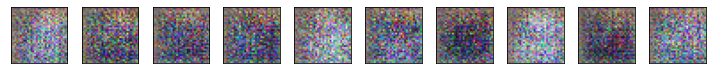

Epoch:   6/30 Discriminator Loss:  0.5010  Generator Loss:  3.4731
Epoch:   7/30 Discriminator Loss:  0.7582  Generator Loss:  2.6403
Epoch:   8/30 Discriminator Loss:  0.5535  Generator Loss:  3.2738
Epoch:   9/30 Discriminator Loss:  1.7672  Generator Loss:  1.7980
Epoch:  10/30 Discriminator Loss:  1.2257  Generator Loss:  3.1849


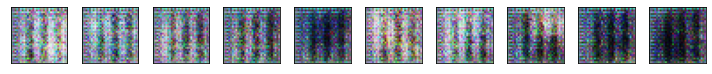

Epoch:  11/30 Discriminator Loss:  0.9833  Generator Loss:  5.9734
Epoch:  12/30 Discriminator Loss:  0.6615  Generator Loss:  5.9615
Epoch:  13/30 Discriminator Loss:  0.8769  Generator Loss:  4.2006
Epoch:  14/30 Discriminator Loss:  0.5106  Generator Loss:  1.8936
Epoch:  15/30 Discriminator Loss:  0.7352  Generator Loss:  1.5525


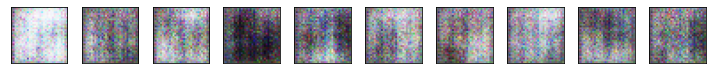

Epoch:  16/30 Discriminator Loss:  0.8532  Generator Loss:  4.5858
Epoch:  17/30 Discriminator Loss:  1.1971  Generator Loss:  2.0261
Epoch:  18/30 Discriminator Loss:  2.5867  Generator Loss:  3.6982
Epoch:  19/30 Discriminator Loss:  1.6283  Generator Loss:  2.4291
Epoch:  20/30 Discriminator Loss:  0.2203  Generator Loss:  5.9381


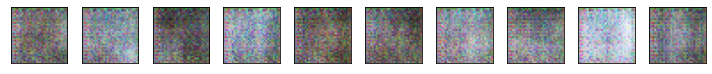

Epoch:  21/30 Discriminator Loss:  0.9498  Generator Loss:  2.4681
Epoch:  22/30 Discriminator Loss:  2.1845  Generator Loss:  3.9888
Epoch:  23/30 Discriminator Loss:  1.3904  Generator Loss:  4.7585
Epoch:  24/30 Discriminator Loss:  1.5392  Generator Loss:  5.0845
Epoch:  25/30 Discriminator Loss:  0.5566  Generator Loss:  4.5224


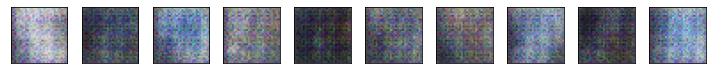

Epoch:  26/30 Discriminator Loss:  0.3316  Generator Loss:  3.1305
Epoch:  27/30 Discriminator Loss:  0.7492  Generator Loss:  2.3119
Epoch:  28/30 Discriminator Loss:  0.5829  Generator Loss:  2.8387
Epoch:  29/30 Discriminator Loss:  1.8454  Generator Loss:  2.5069
Epoch:  30/30 Discriminator Loss:  1.5596  Generator Loss:  3.5765


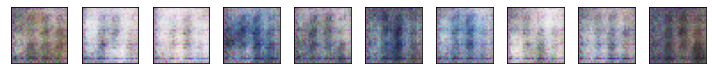

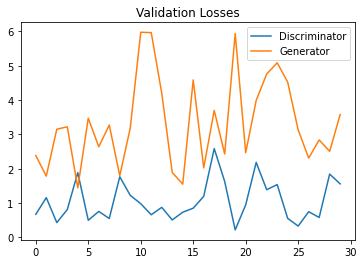

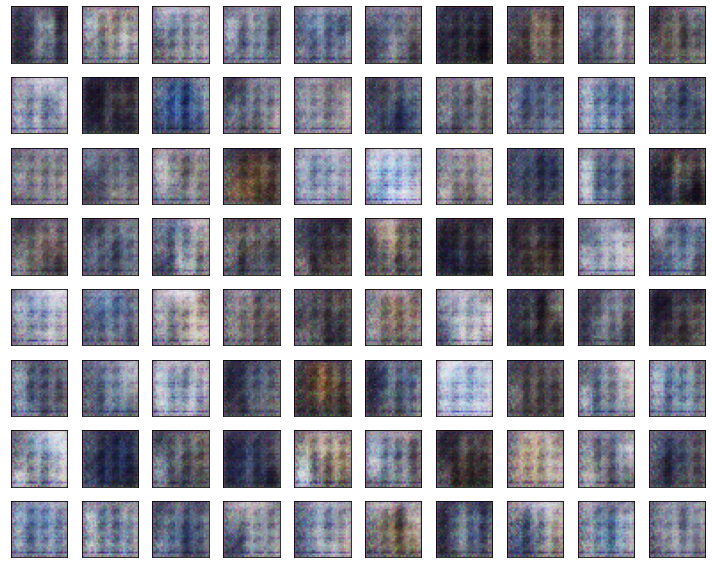

In [ ]:
train(g_learning_rate=0.000001, g_beta_1=0.5, d_learning_rate=0.005,d_beta_1=0.5,leaky_alpha=0.2,epochs=30)

## **2.7 Conclusion**

1. Overall, the training 2 performed the best in terms of realness of the generated images;
2. DCGANs are very sensitive to hyperparameters, More hyperparameter tuning should be experimented if we want to improve further;
3. Limited by computing power and speed, we couldn't try some more sets of parameters, which leads to a not outstanding result of our DCGAN.